# Computer Vision Tutorial: Handwritten Digit Recognition

In this tutorial, we will build a computer vision program capable of recognizing images depicting digits between 0 and 9. Handwritten digit recognition is considered one of the simpler tasks in image recognition, although it was a challenging problem before the advent of modern machine learning techniques. By the end, you should have a model achieving an accuracy of approximately 99%, comparable to human performance.

This tutorial will consist in building several models:
 1. a simple neural network with one layer
 2. a neural network with several layers (the notorious multi layer perceptron)
 3. a convolutional neural network

You can load the solutions by uncommenting some sections the end, but try to solve the exercises first :).


## Install pytorch:
**As pytorch installation takes some time, start the installation before reading the exercises.**
To proceed, you need to have at least `pytorch` installed. Having `torchvision` will allow you to directly download the dataset but is not mandatory. In case the installation of torchvision fails, you can download the dataset here http://yann.lecun.com/exdb/mnist/ .
Installation commands may vary depending on your operating system (Linux/Mac/Windows) and whether you want to use a virtual environment.

With pip:

`pip install torch torchvision`

With conda:

`conda install pytorch torchvision torchaudio cpuonly -c pytorch`

with Conda and a GPU, replace cuda_version with your version:

`conda install pytorch torchvision torchaudio cudatoolkit=cuda_version -c pytorch`

**Gpu acceleration:** The PyTorch library facilitates GPU usage for accelerated computation. However, installing CUDA drivers can be time-consuming. To optmize your time, I recommend focusing on the exercises first, which are not meant to be computationnaly extremely extensive, and deferring the driver installation until later.

In [ ]:
!pip install torch torchvision

# Problem decomposition
Given an image, we want to write a program that predicts the value depicted. The problem can be decomposed in several parts:
- transforming the image into a vector of numbers (embedding),
- apply the vector to a predictor function,
- evaluate the most likely digit from the output.

In our case, the embedding is quite simple as images are described as pixels, which are 2D vectors. Embedding in our case is quite straightforard, but can be tricky in other situations, such as the embedding of 3D objects such as molecules. The output of our function will be a vector of size 10 with each element being a probability between 0 and 1, representing how likely the element of the vector represent the digit on the picture. The hard part consist in finding a function that, given our embedded vector as input, returns an output giving the correct label most of the time.



![problem](single_digit_function.jpg)

# 1. Download and plot samples from the dataset


An crucial aspect of the work in machine learning, often overlooked, involves the creation of the dataset. Choosing relevant samples, ensuring they are correct, performing scaling operations and more.

As this step can be tedious and highly specific to each dataset, you will download an existing dataset and plot some samples. The dataset consist in 60000 handwritten digits that have been numerized in pictures of 28 pixels, more details in:
https://en.wikipedia.org/wiki/MNIST_database

You do not have to write any code in this section.

In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn


In [2]:
# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
host = torch.device("cpu")

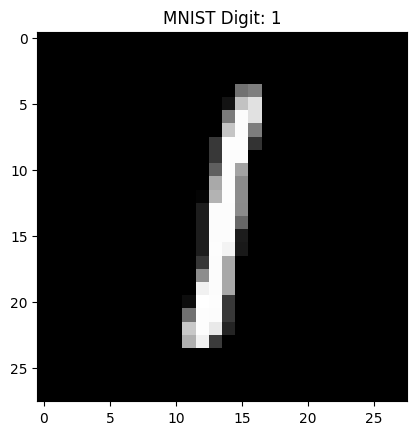

shape of sample (28, 28)


In [7]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download the first four files from this website:
# http://yann.lecun.com/exdb/mnist/
# and place them in the folder MNIST_dataset
path_to_MNIST = './MNIST_dataset'
train_dataset = torchvision.datasets.MNIST(root=path_to_MNIST, train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root=path_to_MNIST, train=False, download=True, transform=transform)

# picking randomly an individual sample
idx_sample = np.random.randint(0, len(train_dataset))
image, label = train_dataset[idx_sample]

# Convert the PyTorch tensor to a NumPy array
image = image.numpy().squeeze()

# Plot the image
plt.imshow(image, cmap='gray')
plt.title(f'MNIST Digit: {label}')
plt.show()

# show the image in numbers
np.set_printoptions(precision=3)
print('shape of sample', image.shape)



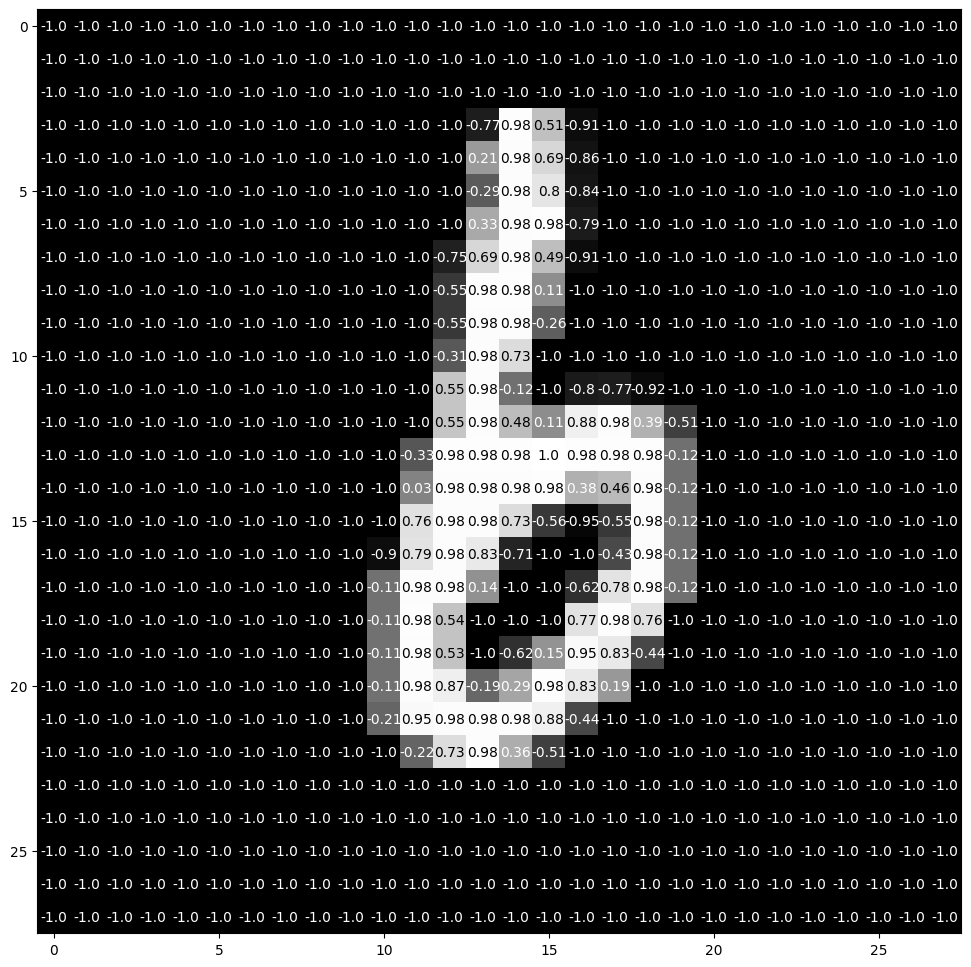

In [4]:
# small code samples taken from https://www.kaggle.com to vizualize values 

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(image, cmap='gray')
width, height = image.shape
thresh = image.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(image[x][y],2) if image[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if image[x][y]<thresh else 'black')




***
In this type of classifications problems, it is important to check if the different categories are roughly balanced. Ideally, no single category should dominate the dataset.
***

In [ ]:
# acess the labels with train_dataset.targets
# Use torch.bincount to count occurrences of each label
label_counts = torch.bincount(train_dataset.targets)

for label, count in enumerate(label_counts):
    print(f"Label {label}: Count {count}")

In [ ]:
# we define data loaders for the rest of the exercise
# the loaders allow to iterate on sample easily,
# the purpose of this notebook is to create a model
# so code that manipulates data is kept to a 
# minimum and decoupled from this notebook.

# Define a batch size of 64
batch_size = 64

#shuffling the training set is usually a good idea
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# 2. Define the Neural network architecture

Given a vector $\textbf{x}$ representing an image, our goal is to define a function $\hat y = f_\textbf{w}(\textbf{x})$ that outputs probabilities for each label. In our case, if $\textbf{x}$ corresponds to an image depicting the digit "2," a satisfactory prediction might be $\hat y = (0.1, 0.05, 0.9, 0.2, 0.1, 0.02, 0.1, 0.3, 0.4, 0.1)$, where the highest value in $\hat y$ indicates the most probable label for our image.
    
The objective during training is to determine the parameters $\textbf{w}$ such that the predicted labels are accurate for all images. This involves comparing the predicted vector $\hat y$ with the target vector $y_{\rm True} = (0, 0, 1, 0, 0, 0, 0, 0, 0, 0)$, where the "1" corresponds to the true label.

![multi layer perceptron](single_layer_MNIST.png)

We will construct a multi-layer perceptron (MLP) following the structure depicted in the figure above. Initially, we begin with a single layer. Our MLP is made of several artificial neurons, represented in blue, and connexions between them, represented as lines. Below we zoom on a single neuron. Each artificial perform a very basic operation, it multiplies the input $\textbf{x}$ by the weights $\textbf{w}$ and add a bias $b$. Then it applies a non-linear function $g$ and outputs $g(\textbf{w} \textbf{x} + b)$. Any non linear function $g$ could fit, but good choices could be the sigmoid or the Relu functions (note that in deep learning, "good" usually means approved empirically and the theoretical arguments driving choices are close to zero).

![multi layer perceptron](single_neuron_zoom.jpg)

<span style="font-size:16px;">

    
To build our network of articial neurons, we'll implement a class that inherits from **torch.nn.Module**. This approach allows us to focus solely on defining the architecture without delving into the intricate details of individual neurons and their connexions.
    
We have to define the parameters of the architecture that depends on our problem at hand:

- What is the size of the input?
- What is the size of the output?
- Choose the number of hidden neurons, bigger means a more flexible model, smaller means faster training time
- Choose an activation function

The documentation of pytorch is a good start:
https://pytorch.org/docs/
</span>


In [ ]:
# Define the MLP model with ReLU and Dropout
class Single_layer_perceptron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_function):
        super(Single_layer_perceptron, self).__init__()
        self.input_size = input_size

        # define a linear layer from https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.hidden_layer = ...
        # 
        self.non_linear_activation = activation_function

        self.output_layer = nn.Linear(hidden_size, output_size)

    # Define the forward function, given an image as entry, should return
    # a probability for each label
    def forward(self, x):
        # x has a shape batch_sizex 1 x 28 x 28, it must be flatten to batch_size x 1 x 784 instead
        x = x.reshape(-1, 1 * self.input_size * self.input_size)

        hidden_output = self.hidden_layer(x)
        hidden_output = self.non_linear_activation(hidden_output)

        # Pass the hidden layer output through the output layer, which is usually just a linear layer
        y_pred = self.output_layer(hidden_output)
        return y_pred

# Define the number of neurons for the hidden layer, typically a power of 2
num_neurons = ...

# Create an instance of the custom neural network
pixel_size = ... # input size
output_size = ...  # output size
activation_function = ... # standard choices are relu, sigmoid, or tanh
# Instantiate the model
single_layer = Single_layer_perceptron(pixel_size, num_neurons, output_size, activation_function)
# transfer the model to the gpu device (if there is one)
single_layer = single_layer.to(device)

<span style="font-size:16px;">
We need to defing an optimizer and a loss function. The purpose of the optimizer is to iteratively update the model parameters $\textbf{w}$ during training to minimize the loss function $L(y_{\rm True}, \hat y)$, guiding the model towards better performance. You also need to define the learning rate, which controls the size of the steps taken during optimization, and is a very important hyperparameter which strongly influence convergence. You should try several values.

</span>


In [ ]:
#### uncomment to see a solution 
### %load solutions_pytorch/single_layer_solution.py
####

# 3. Do the training

We have defined an architecture and we have a function that depends on parameters. In the initial stage, we randomly selected the parameters, resulting in a function that is likely to perform poorly in recognizing digits—no better than random chance.

![first_evaluation](first_evaluation.jpg)

We need to improve the parameters of our function, a part that is called training in machine learning slang. The training consist in forward and backward passes, where the forward pass evaluate our function and the backward pass compute gradients of the function to update the parameters of our model. The objective is to iteratively reduce the loss.

![multi layer perceptron](training_nn_2.png)

Eventually, our function will be better at recognizing digits, reaching something like this:

![multi layer perceptron](final_evaluation.jpg)

To write the training function, you need to define:
- a loss function
- the step of the gradient descent (called the learning rate)
- the numerical scheme for the optimization
- the maximum number of epochs

To get help, I strongly recommend to get help from existing examples, such as https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

In [ ]:
#### Define loss functions and optimizer

# specify loss function, cross entropy is the standard choice here
loss_function = ...

# specify optimizer and learning rate
# a strong learning rate means the weights are updated a lot at each iteration, 
# however, a too big learning rate will make you miss a narrow minimum
# If you see strong oscillations in error, it is too big, if nothing changes in a few epochs it is too small
learning_rate = ...
optimizer_single_layer = ...# see https://pytorch.org/docs/stable/optim.html for possible optimizers

In [ ]:
# Training loop function
def train_model(num_epochs, model, train_loader, test_loader, criterion, optimizer, save_name=''):
    """
    perform the training of the model with the data in train_loader.
    Save the models as a file .pt at all epochs in the notebook folder.
    
    epochs: integer, training ends when model saw the data for
            the number of epochs
    model: the neural network, a pytorch model
    train_loader: an iterable over the dataset that contains data and labels
    optimizer: an optimizer (SGD, Adam...) from torch.optim
    """
    model.to(device)
    save_path = '.'

    model_names = [] #names of the saved models
    for epoch in range(num_epochs):
        model.train()
        
        train_loss = 0 # monitor loss
        for images, labels in train_loader:
            ### remark, a more efficient way would be to define the Dataloader directly on the GPU.
            ### we keep it this way for the sake of simplicity
            images, labels = images.to(device), labels.to(device)

            # pitfall, you have to clear the gradients at each step
            # Otherwise, pytorch accumulate gradients (which is useful for other architectures like RNN)    
            optimizer.zero_grad()
            # forward pass: call the forward function you defined to predicted outputs \hat{y}
            outputs = ...
            # calculate the loss
            loss = ...
            # backward pass: compute gradient of the loss with respect to model parameters
            ...
            # update the parameters using the optimizer
            ...

            # keep track of loss, the .item() is necessary only if loss is a torch.tensor
            train_loss += loss.item()

        train_loss /= (len(train_loader) * batch_size)

        # Validation
        model.eval()
        total_correct = 0
        test_loss = 0

        # the no_grad can be used when testing to make it more efficient, but it is not necessary
        with torch.no_grad():
            for images, labels in test_loader: 
                # here we loop on test examples, we do not modify the parameters, 
                # we only evaluate the function here
                images, labels = images.to(device), labels.to(device)
                # same as a forward pass, evaluate the image with the forward function
                outputs = ...
                # choose the most likely digit from the output of the nueral network
                _, predictions = ...
                total_correct += (predictions == labels).sum().item()

                # we monitor the test loss
                test_loss += criterion(outputs, labels).item()

        # normalize by number of samples in test
        accuracy = 100 * total_correct / (len(test_loader) * batch_size)
        test_loss /= (len(test_loader) * batch_size)
        print(f'Epoch {epoch+1}/{num_epochs}, train loss: {train_loss:.4f}', end=" ")
        print(f'test loss {test_loss}, test Accuracy: {accuracy:.4f}')

        # Save model checkpoint after each epoch
        checkpoint_path = f'{save_path}/{save_name}_{epoch+1}.pt'
        model_names.append(checkpoint_path)
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'accuracy': accuracy,
        }, checkpoint_path)
    print('Training complete.')
    return model_names

In [ ]:
####uncomment to see a solution 
### %load solutions_pytorch/training.py
####

In [ ]:
# perform the training, i.e. the forward and backward passes on all data
# Check the accuracy, with the single layer, you should at least get 80% after a single epoch.
n_epochs = 5
single_layer_model_names = train_model(n_epochs, single_layer, train_loader, 
                                       test_loader, loss_function,
                                       optimizer_single_layer,
                                       save_name='single_layer')

<span style="font-size:16px;">
Let's randomly select an image from the test set, one that our model hasn't encountered during training, and assess whether the label predicted by our latest model is accurate.
 </span>

In [ ]:
def plot_image_from_test(test_dataset, model_name):
    checkpoint = torch.load(model_name)
    # load the dict that contains all the parameters of our model dict
    single_layer.load_state_dict(checkpoint['model_state_dict'])
    single_layer.to(device)
    # prepare the model for evaluation
    single_layer.eval()

    # choose a random sample
    test_sample = np.random.randint(0, len(test_dataset))
    image, label = test_dataset[test_sample]
    image = image.to(device)

    # same as the forward pass
    output = single_layer(image)

    _, label_pred = torch.max(output, 1)

    # Plot the image
    # Convert the PyTorch tensor to a NumPy array
    image = (image.to(host)).numpy().squeeze()
    plt.imshow(image, cmap='gray')
    plt.title(f'MNIST Digit: {label}, prediction: {label_pred[0]}')

# take the last model
model_name = single_layer_model_names[-1]
plot_image_from_test(test_dataset, model_name)

### Question
<span style="font-size:16px;">
Intuitively the last model with the most epochs should perform better, as it did more steps to reduce the loss. Is this always the case? Is the accuracy the same on the training set and on the test set?
</span>

In [ ]:
# create an array that save accuracy for each models
def plot_loss_and_accuracy(model, model_names, test_loader, loss_function):
    
    accuracies = []
    train_losses = []
    test_losses = []

    for i, (model_name) in enumerate(model_names):
        checkpoint = torch.load(model_name)
        epoch = checkpoint['epoch']
        test_losses.append(checkpoint['test_loss'])
        train_losses.append(checkpoint['train_loss'])
        accuracies.append(checkpoint['accuracy'])

    # Create a single figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    # Plot accuracy on the first subplot
    ax1.plot(accuracies, label='accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy Plot')

    # Plot loss on the second subplot
    ax2.plot(test_losses, label='test loss')
    ax2.plot(train_losses, label='train loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss Plot')
    
    plt.legend()
    plt.show()

In [ ]:
# plot the loss and the accuracy as a function of epochs
plot_loss_and_accuracy(single_layer, single_layer_model_names, test_loader, loss_function)

### Question:
<span style="font-size:16px;">

What happens with a too big learning rate? or a too small?
</span>


# 4. add more layers

![multi layer perceptron](several_layers_crop.jpg)

<span style="font-size:16px;">
    The model used in the previous section only used a single hidden layer. Even though a single layer can approximate any function (more details in https://en.wikipedia.org/wiki/Universal_approximation_theorem), it is usually beneficial to have a model with several layers. Empirically, a model with several layers will typically beat a model with a single layer, even if they have the same number of parameters. But you will see that comes at a cost, and training might be harder to perform.

When building a model, testing several architectures is extremely important, that is why you should:
- Write code that allows model changes easily
- Find a way to do bookepping of the several models
The bookepping consist in keeping a trace of all the models you trained,  there are good tools online like the open-source mlflow (https://mlflow.org/) or weight and biases (https://wandb.ai/site ).

To do this section, you must:
- Explicitly define a batch size, which was set to one in the previous part
- Add some kind of regularization (use Dropout)
</span>

In [ ]:
# We now define a model with several layers and dropout
class Multi_layers(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size,
                 activation_function, dropout_prob=0.25):
        super(Multi_layers, self).__init__()
        
        self.input_size = input_size
        
        # we can create a model with three layers, but you can add use a different architecture
        
        self.hidden_layer_1 = ...
        self.activation1 = ...
        self.dropout1 = ...

        self.hidden_layer_2 = ...
        self.activation2 = ...
        self.dropout2 = ...

        self.hidden_layer_3 = ...
        self.activation3 = ...
        self.dropout3 = ...

        self.output_layer = ...

    # Define the function, given an image as entry, should return
    # a probability for each label 
    def forward(self, x):
        # reshape x to the correct shape
        x = ...
        
        # For each layer
        # the input x pass through the hidden layer and you
        # - apply the linear transformation w x + b
        # - apply the non linear activation function \sigma(w x + b)
        # - apply the dropout regularization with torch.nn.Dropout
        
        # every output is called x to make things clearer
        # remember that each x may have a different shape
        # from layer to layer.
        
        # layer 1, linear transformation, activation and dropout
        x = ...
        x = ...
        x = ...

        # layer 2
        x = ...
        x = ...
        x = ...

        # layer 3
        x = ...
        x = ...
        x = ...
        
        # output layer
        x = ...

        return x

# choose a number of neurons for each layer. 
neurons = [..., ..., ...]

pixel_size = ...
output_size = ...
activation_function = ... # you can choose a different function for each layer, or the same

# Several_layers = Several_layer_perceptron(pixel_size, neurons, output_size, activation_function)
multi_layers = Multi_layers(pixel_size, neurons, output_size,
                            activation_function, dropout_prob=0.2).to(device)

# Print the number of parameters in each layer
for name, param in multi_layers.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")


In [ ]:
####uncomment to see a solution 
### %load solutions_pytorch/several_layers.py
####

In [ ]:
# specify loss function
loss_function_multi_layers = nn.CrossEntropyLoss()

# specify optimizer and learning rate
learning_rate = 0.05
optimizer_multi_layer = torch.optim.Adam(multi_layers.parameters(), lr=learning_rate)

In [ ]:
# The training can be called as before with no modifications to the function
n_epochs = 10
multi_layer_model_names = train_model(n_epochs, multi_layers, train_loader,
                                      test_loader, loss_function_multi_layers,
                                      optimizer_multi_layer, batch_size,
                                      save_name='multi_layers')

### Question (Hard):
<span style="font-size:16px;">
When plotting train and test loss, you may see that the train loss is bigger than the test loss, which seems like a mistake. How can you explain this?
    </span>
    

In [ ]:
plot_loss_and_accuracy(multi_layers, multi_layer_model_names,
                       test_loader, loss_function_multi_layers)

# 5. Use a convolutionnal neural network

<span style="font-size:16px;">
    In this section, we introduce briefly the Convolutional Neural Network (CNN), which is a specialized type of neural network designed for image-related tasks. While the models we defined in the previous section are effective for general pattern recognition, CNNs are tailored specifically for visual data.

So far, our models have been very basic. We treated the input to our function as a flat sequence of pixels, neglecting any geometric information. By bruteforce, we searched for a function in a huge function space of 784 dimensions. This simplistic approach won't suffice for handling more intricate images, such as those found in ImageNet, that contains 256\*256 pixels and 3 colors. Additionnally we do not use translationnal invariance, implying that translations of two images depicting the same digit may produce different outputs.

To alleviate this issues, we will use convolutionnal neural network, which will greatly improve our performance.

In a nutshell, CNNs are build upon multi layer perceptrons like the one we wrote in previous sections, but introduce other types of layers, namely,
- **convolutional layers** 
The convolution operation is similar to a standard discrete convolution of two functions $f * g$, where $f$ is a learnnable kernelof a size we choose and $g$ the image. The kernel is used to scan input images and can extract local patterns such as edges.
- **pooling layers**, that reduce spatial dimensions while keeping features of images

 To learn more, Deep Learning from Goodfellow describe it precisely and gives good insight https://www.deeplearningbook.org/
 
 To visualize the effect of the different parameters, see the animations in https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
</span>

In [ ]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, output_size, in_channels, kernel_size, 
                 out_channels, dropout_prob=0.2):
        super(SimpleCNN, self).__init__()
        pixel_size = 28 # change this value for other images
        # This padding value is probably not the optimal value,
        # but allows to have simple expression for the dimensions
        # of the layers.
        padding = kernel_size // 2

        # we take the architecture to be first a layer with
        # a convolution, activation and pooling
        # fill the arguments of the convolution layer
        self.conv1 = nn.Conv2d(...)
        # output: (28 - kernel_size + 1) + 2 * padding
        self.relu1 = nn.ReLU()

        # choose a pooling function
        # the most common pooling function is max pooling, which take the maximum value 
        # in a square defined by the kernel size
        self.pool1 = ...
        self.dropout1 = nn.Dropout(dropout_prob)

        self.conv2 = nn.Conv2d(...)
        self.relu2 = nn.ReLU()
        self.pool2 = ...
        self.dropout2 = nn.Dropout(dropout_prob)

        # Now the input must be flatten to be in the last two layers
        self.flatten = nn.Flatten()
        hidden_neurons = 128
        
        ### careful! The dimension of this layer might be incorrect if:
        # - you change the kernel size in maxpool2d
        # - you change the padding
        self.fc1 = nn.Linear(out_channels * (pixel_size // 4)**2, hidden_neurons)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_neurons, output_size)

    def forward(self, x):
        # Important, note that the image is not flatten, unlike with the previous models
        # we keep the structure of the 2D image intact, which allows to keep
        # spatial information.
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # only here, after several layers we flatten the array
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x

activation_function = torch.relu # choose relu again
# number of channels (i.e. colors) going in
conv_in_channels = ...
# define the number of learnable kernels
conv_out_channels = ...
# choose the kernel size, 3 is the minimum, can also be rectangular but this complicated the output size
kernel_size = ...

# Several_layers = Several_layer_perceptron(pixel_size, neurons, output_size, activation_function)
CNN_model = SimpleCNN(output_size, conv_in_channels, kernel_size,
                      conv_out_channels).to(device)


print(CNN_model)

In [ ]:
####uncomment to see a solution 
### %load solutions_pytorch/convolutionnal_neural_network.py
####

### Question
<span style="font-size:16px;">

If in the first convolutionnal layer you use no padding, a kernel of size 3x3, and fix out_channel to 20, what is the output size of the layer? 
</span>


In [ ]:
# As usual, specify loss function
loss_function_conv = nn.CrossEntropyLoss()

# specify optimizer and learning rate
learning_rate = 0.05
optimizer_conv = torch.optim.SGD(CNN_model.parameters(), lr=learning_rate)

In [ ]:
# Training again, you should easily get above 95 %
n_epochs = 5
CNN_model_names = train_model(n_epochs, CNN_model, train_loader,
                              test_loader, loss_function_conv, 
                              optimizer_conv, batch_size,
                              save_name='CNN')

In [ ]:
plot_loss_and_accuracy(multi_layers, CNN_model_names,
                       test_loader, loss_function_multi_layers)

## Some last remarks
If you made it here, you should have several models to recognize digits, including a CNN with likely 98\%+ accuracy. You can now use these codes as a starting point for your applications. However, keep in mind that they are relatively basic, and works mostly because the MNIST dataset is relatively simple and contains lots of samples. 

### Real applications
In practice, you may face several difficulties to have a working and useful model. For instance, because collecting data is expensive, it is likely that you only have access to a much smaller dataset. You may have access to only a hundred of samples. In that case, training a model from scratch is probably not a good approach. You should probably look if someone already solved a problem similar to yours. In that case, adapting its model will be a lot faster.

### more challenging datasets
 - CIFAR10: colored images with 10 labels
 - ImageNet (you may need more than your laptop to get a decent score).

